# NYC Squirrel Census

## 1. Import Libraries

In [199]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

# The following libraries are for mapping
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
from geodatasets import get_path
import contextily as cx


## 2. Load the Dataset

In [200]:
df = pd.read_csv("data/squirrels.csv")

## 3. Understand the Data

In [201]:
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3023 entries, 0 to 3022
Data columns (total 31 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   X                                           3023 non-null   float64
 1   Y                                           3023 non-null   float64
 2   Unique Squirrel ID                          3023 non-null   object 
 3   Hectare                                     3023 non-null   object 
 4   Shift                                       3023 non-null   object 
 5   Date                                        3023 non-null   int64  
 6   Hectare Squirrel Number                     3023 non-null   int64  
 7   Age                                         2902 non-null   object 
 8   Primary Fur Color                           2968 non-null   object 
 9   Highlight Fur Color                         1937 non-null   object 
 10  Combination 

On initial preview, there are not many null values in the dataset, so I will continue investigating the dataset. Specific location and color notes will likely need to be deleted because many values are null.

In [202]:
df.head()

,X,Y,Unique Squirrel ID,Hectare,Shift,Date,Hectare Squirrel Number,Age,Primary Fur Color,Highlight Fur Color,...,Kuks,Quaas,Moans,Tail flags,Tail twitches,Approaches,Indifferent,Runs from,Other Interactions,Lat/Long
0,-73.956134,40.794082,37F-PM-1014-03,37F,PM,10142018,3,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,NaN,POINT (-73.9561344937861 40.7940823884086)
1,-73.968857,40.783783,21B-AM-1019-04,21B,AM,10192018,4,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,NaN,POINT (-73.9688574691102 40.7837825208444)
2,-73.974281,40.775534,11B-PM-1014-08,11B,PM,10142018,8,NaN,Gray,NaN,...,False,False,False,False,False,False,False,False,NaN,POINT (-73.97428114848522 40.775533619083)
3,-73.959641,40.790313,32E-PM-1017-14,32E,PM,10172018,14,Adult,Gray,NaN,...,False,False,False,False,False,False,False,True,NaN,POINT (-73.9596413903948 40.7903128889029)
4,-73.970268,40.776213,13E-AM-1017-05,13E,AM,10172018,5,Adult,Gray,Cinnamon,...,False,False,False,False,False,False,False,False,NaN,POINT (-73.9702676472613 40.7762126854894)


Most columns contain categorical data which can make analysis more difficult; however, since many columns are True/False they can easily be analyzed through pie-charts and other means also used for numerical data.

## 3. Data Cleaning

In [203]:
df.isna().sum() / df.shape[0] * 100

X                                              0.000000
Y                                              0.000000
Unique Squirrel ID                             0.000000
Hectare                                        0.000000
Shift                                          0.000000
Date                                           0.000000
Hectare Squirrel Number                        0.000000
Age                                            4.002646
Primary Fur Color                              1.819385
Highlight Fur Color                           35.924578
Combination of Primary and Highlight Color     0.000000
Color notes                                   93.979491
Location                                       2.117102
Above Ground Sighter Measurement               3.771088
Specific Location                             84.254052
Running                                        0.000000
Chasing                                        0.000000
Climbing                                       0

Columns with >10% null data should be investigated. I will delete the following columns: 
* Highlight Fur Color
* Color notes   
* Specific Location 
* Other Activities  
* Other Interactions
I will delete the following irrelevant columns:
* Combination of Primary and Highlight Color

## 4. Data Processing/Preparation

### 4.1 Drop unnecessary columns

In [204]:
df.columns

Index(['X', 'Y', 'Unique Squirrel ID', 'Hectare', 'Shift', 'Date',
       'Hectare Squirrel Number', 'Age', 'Primary Fur Color',
       'Highlight Fur Color', 'Combination of Primary and Highlight Color',
       'Color notes', 'Location', 'Above Ground Sighter Measurement',
       'Specific Location', 'Running', 'Chasing', 'Climbing', 'Eating',
       'Foraging', 'Other Activities', 'Kuks', 'Quaas', 'Moans', 'Tail flags',
       'Tail twitches', 'Approaches', 'Indifferent', 'Runs from',
       'Other Interactions', 'Lat/Long'],
      dtype='object')

Columns are named correctly, so no need to rename. 

In [205]:
df = df[['X', 'Y', 'Unique Squirrel ID', 'Hectare', 'Shift',
       'Age', 'Primary Fur Color',
       'Running', 'Chasing', 'Climbing', 'Eating',
       'Foraging', 'Kuks', 'Quaas', 'Moans', 'Tail flags',
       'Tail twitches', 'Approaches', 'Indifferent', 'Runs from']]
df.shape

(3023, 20)

### 4.2 Check for duplicates

In [206]:
df.duplicated().sum()

0

In [207]:
df.duplicated(["Unique Squirrel ID"]).sum()

5

Zero duplicated entries, but five squirrels were spotted more than once. I will delete the duplicates so I don't overcount a squirrel. 

In [208]:
df.loc[df.duplicated(["Unique Squirrel ID"], keep=False)].sort_values(["Unique Squirrel ID"])

,X,Y,Unique Squirrel ID,Hectare,Shift,Age,Primary Fur Color,Running,Chasing,Climbing,Eating,Foraging,Kuks,Quaas,Moans,Tail flags,Tail twitches,Approaches,Indifferent,Runs from
2532,-73.976620,40.766191,1F-AM-1010-04,01F,AM,Adult,Gray,False,False,False,True,False,False,False,False,False,False,False,True,False
2613,-73.976588,40.766095,1F-AM-1010-04,01F,AM,Adult,Gray,False,False,False,True,False,False,False,False,False,False,False,True,False
104,-73.957044,40.794851,37E-PM-1006-03,37E,PM,Adult,Gray,True,False,False,False,False,False,False,False,False,False,False,False,True
2271,-73.956967,40.794879,37E-PM-1006-03,37E,PM,Adult,Gray,True,False,False,False,False,False,False,False,False,False,False,False,True
1540,-73.957711,40.798406,40B-AM-1019-06,40B,AM,Juvenile,Gray,False,False,False,False,True,False,False,False,False,False,False,False,True
2167,-73.958236,40.798775,40B-AM-1019-06,40B,AM,Juvenile,Gray,False,False,False,False,True,False,False,False,False,False,False,False,True
2106,-73.977262,40.769282,4C-PM-1010-05,04C,PM,Adult,Gray,True,False,False,False,False,False,False,False,False,False,False,False,False
2888,-73.977165,40.769305,4C-PM-1010-05,04C,PM,Adult,Gray,True,False,False,False,False,False,False,False,False,False,False,False,False
517,-73.974945,40.772066,7D-PM-1010-01,07D,PM,Adult,Gray,True,False,False,False,False,False,False,False,False,False,False,False,False
2234,-73.974852,40.771959,7D-PM-1010-01,07D,PM,Adult,Gray,True,False,False,False,False,False,False,False,False,False,False,False,False


In [209]:
df = df.sort_values(["Unique Squirrel ID"]).reset_index(drop=True)
df = df.drop_duplicates(["Unique Squirrel ID"], keep="first").reset_index(drop=True)

In [210]:
df.shape

(3018, 20)

While I have dropped the known duplicates of entries that described the same squirrel, there are likely still some squirrels that were counted twice accidentally. There are many equations that help determine population size from a census, such as V. F. Flyger's 1959 squirrel equation which would estimate that there are roughly ~2,300 squirrels in Central Park; however, since I do not have the statistics background to determine which equation to use, for the sake of this analysis I will assume there are 3,018 squirrels.

## 5. Univariate Analysis

### 5.1 Squirrel colors

Text(0.5, 1.0, 'Central Park Eastern Gray Squirrel Colors')

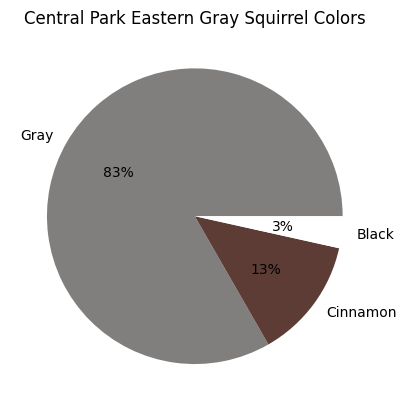

In [211]:
squirrel_colors = ["#807f7e", "#5c3c34", "#ffffff"]
plt.pie(df["Primary Fur Color"].value_counts(), labels=["Gray", "Cinnamon", "Black"], colors=squirrel_colors, autopct='%1.0f%%')
plt.title("Central Park Eastern Gray Squirrel Colors")

All squirrels in Central Park are the same species (Eastern Gray Squirrel), but they can be three different colors. Gray is the most popular.

### 5.2 Age groups

Text(0.5, 1.0, 'Central Park Squirrels by Age Group')

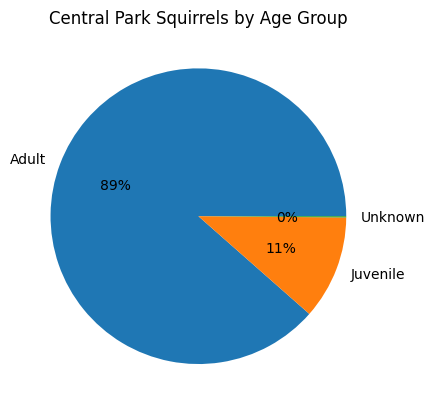

In [212]:
plt.pie(df["Age"].value_counts(), labels=["Adult", "Juvenile", "Unknown"], autopct='%1.0f%%')
plt.title("Central Park Squirrels by Age Group")

Most squirrels are adults, but 11% are juvenile.

### 5.3 Squirrel Activities

In [213]:
activities = ['Running', 'Chasing', 'Climbing', 'Eating',
       'Foraging']

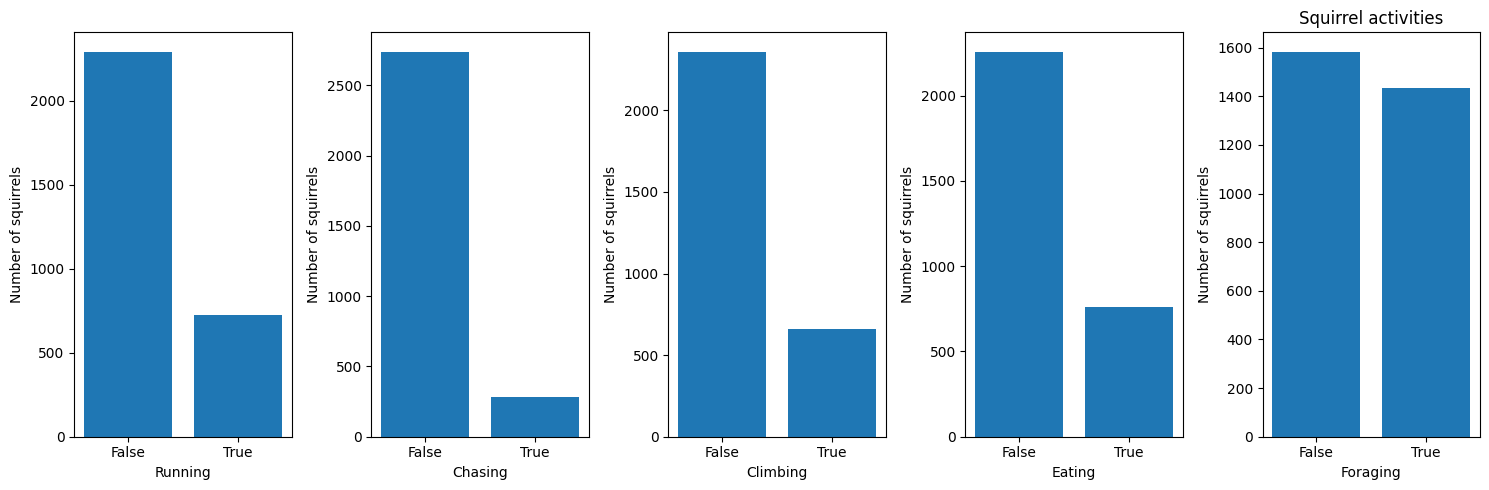

In [214]:
fig = plt.subplots(nrows=1, ncols=len(activities), figsize=(15, 5))
plt.title("Squirrel activities")
for i in range(len(activities)):
    plt.subplot(1, len(activities), i+1)
    plt.bar(["False", "True"], df[activities[i]].value_counts())
    plt.xlabel(activities[i])
    plt.ylabel("Number of squirrels")
plt.tight_layout()

The most common activity for squirrels is foraging.

### 5.4 Squirrel noises

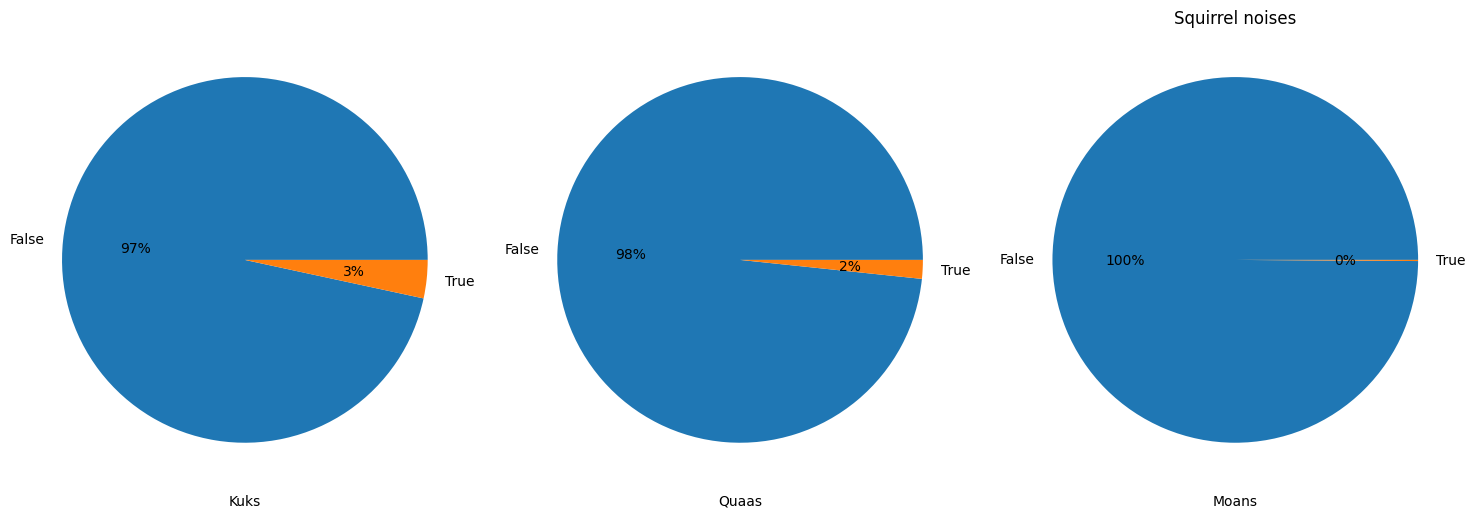

In [215]:
noises = ["Kuks", "Quaas", "Moans"]
fig = plt.subplots(nrows=1, ncols=len(noises), figsize=(15, 5))
plt.title("Squirrel noises")
for i in range(len(noises)):
    plt.subplot(1, len(noises), i+1)
    plt.pie(df[noises[i]].value_counts(), labels=["False", "True"], autopct='%1.0f%%')
    # plt.bar(["False", "True"], df[noises[i]].value_counts())
    plt.xlabel(noises[i])
plt.tight_layout()

Most squirrels made no noise at all, but the most common noise was kuks

### 5.5 Behavior towards humans

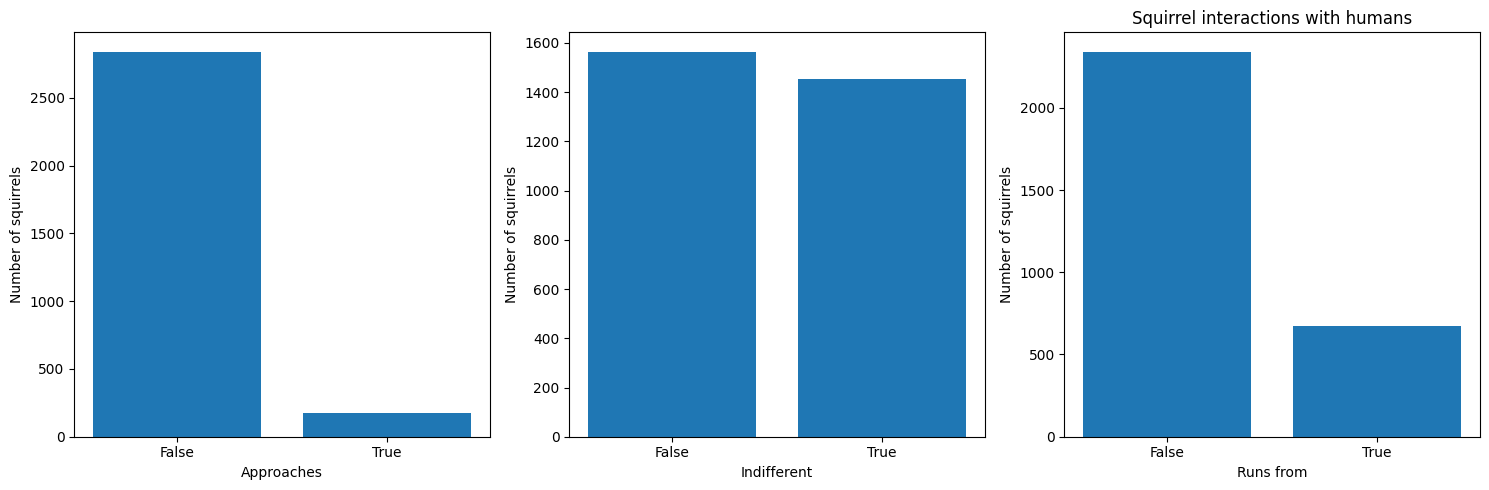

In [216]:
human = ['Approaches', 'Indifferent', 'Runs from']
fig = plt.subplots(nrows=1, ncols=len(human), figsize=(15, 5))
plt.title("Squirrel interactions with humans")
for i in range(len(human)):
    plt.subplot(1, len(human), i+1)
    plt.bar(["False", "True"], df[human[i]].value_counts())
    plt.xlabel(human[i])
    plt.ylabel("Number of squirrels")
plt.tight_layout()

Most of the squirrels were indifferent towards humans, but if they weren't then they more often ran away than approaching.

### 5.6 Mapping location of squirrels in Central Park

In [217]:
# Creating new df with location points
gdf2 = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df["X"], df["Y"]), crs="EPSG:4326"
)

In [218]:
df_wm = gdf2.to_crs(epsg=3857) # Mapping new df to correct scale and system

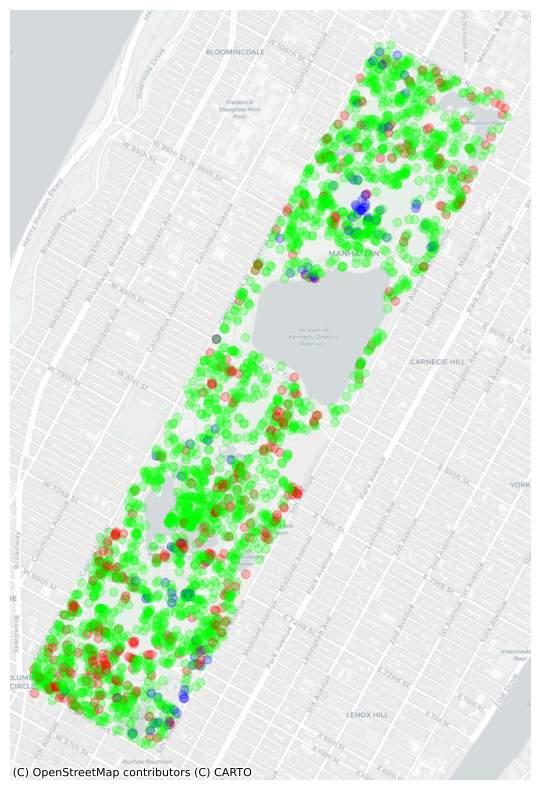

In [219]:
ax = df_wm.plot(figsize=(10, 10), alpha=0.25, column='Primary Fur Color', cmap="brg") # Colored by fur
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
ax.set_axis_off()

Not sure how to label colors, but green is grey, blue is black, and red is cinnamon. Black squirrels tend to congregate together, which is important because black is a recessive trait.

## 6. Multivariate Analysis

### 6.1 Correlation matrix

All columns of interest are categorical but only have 2-3 option, so I will convert the categorical data to numerical for correlation analysis

In [220]:
columns_to_change = ['Age', 'Shift', 'Primary Fur Color', 
       'Running', 'Chasing', 'Climbing',
       'Eating', 'Foraging', 'Kuks', 'Quaas', 'Moans', 'Tail flags',
       'Tail twitches', 'Approaches', 'Indifferent', 'Runs from']
df_num = pd.DataFrame()
for c in columns_to_change:
       df_num[c] = pd.Categorical(df[c]).codes

<Axes: >

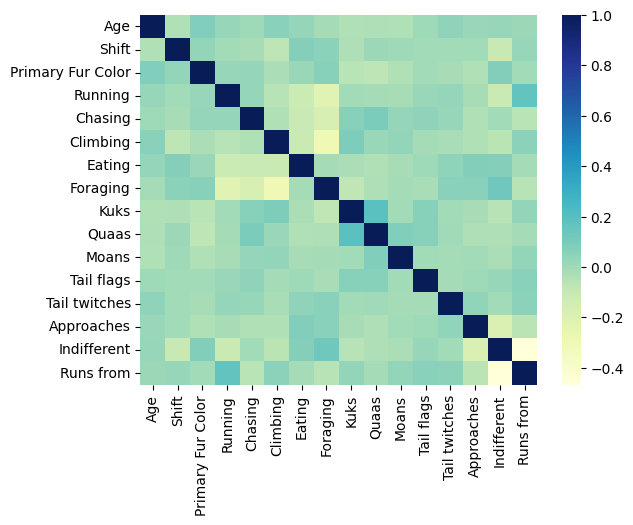

In [221]:
sns.heatmap(df_num.corr(), cmap="YlGnBu") 

The heatmap shows several notable (and possibly significant) correlations:
* Foraging is negatively correlated with running, chasing, and climbing yet positively correlated wih indifferent. This makes sense because squirrels aren't known for their multitasking (so we think).
* Indifferent and running away are nagatively correlating which makes sense because they are largely mutually exclusive.
* Kuks and quaas are positively correlated, which suggests the squirrels either make no noise, or a lot of noise.
* Interestingly, age is not significantly correlated with anything.
* There is some correlation between activity level and time of day

## 7. Statistical Analysis

### Q1: Are squirrels more indifferent in the AM or PM?

In [222]:
percent_in_am = len(df.query("Shift.str.contains('AM') and Indifferent == True")) / len(df.query("Shift.str.contains('AM')")) * 100
percent_in_pm = len(df.query("Shift.str.contains('PM') and Indifferent == True")) / len(df.query("Shift.str.contains('PM')")) * 100
print("AM = " + str(percent_in_am) + "%, PM = " + str(percent_in_pm) + "%")

AM = 53.90334572490706%, PM = 43.51464435146444%


A higher percentage of squirrels are indifferent in the AM hours, than the PM hours.

### Q3: How many squirrels made more than one noise?

In [223]:
len(df.query("Kuks == True and Quaas == True"))

15

15 squirrels made more than one type of noise

### Q3: What % of squirrels interacted with humans?

In [224]:
(len(df.loc[df["Approaches"] == True]) + len(df.loc[df["Runs from"] == True]))/len(df) * 100

28.29688535453943

Only 28% of squirrels interacted with the volunteer completing the census. Suggests squirrels are not very interested in humans